In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12a_autoencoder.ipynb"
_nb_title = "MNIST용 오토인코더"
_nb_message = """
MNIST에 심층 컨볼루션 오토인코더를 훈련한다.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=MNIST%EC%9A%A9+%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F12_generation%2F12a_autoencoder.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12a_autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12a_autoencoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/12_generation/12a_autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>MNIST용 오토인코더</h1>
MNIST에 심층 컨볼루션 오토인코더를 훈련한다.


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


In [2]:
# 라이브러리와 모듈을 임포트
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

## 시각화 유틸리티

In [3]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # 숫자의 n*n 2D 매니폴드를 표시
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # 잠재 공간에서 숫자 클래스의 2D 플롯에 해당하는 선형 간격 좌표
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, data, labels, vae=True):
    # 잠재 공간에 숫자 클래스의 2D 플롯을 표시
    if vae:
      z_mean, _, _ = encoder.predict(data)
    else:
      z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10): # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(cx, cy, str(label), color="white", fontsize=25, fontweight="bold")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## 오토인코더

케라스 유틸리티를 써서 MNIST 데이터를 로딩

In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


인코더는 입력에서 잠재 차원으로 이동:

In [5]:
latent_dim = 2 # 시각화를 쉽게 하기 위해

encoder = tf.keras.Sequential([
    keras.Input(shape=(28, 28, 1), name="image_input"),
    layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="e_conv1"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="e_conv2"),
    layers.Flatten(name="e_flatten"),
    layers.Dense(latent_dim, name="e_dense")
], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e_conv1 (Conv2D)            (None, 14, 14, 32)        320       
                                                                 
 e_conv2 (Conv2D)            (None, 7, 7, 64)          18496     
                                                                 
 e_flatten (Flatten)         (None, 3136)              0         
                                                                 
 e_dense (Dense)             (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


디코더는 잠재 차원에서 재구성된 이미지로 다시 이동:

In [6]:
decoder = tf.keras.Sequential([
    keras.Input(shape=(latent_dim,), name="d_input"),
    layers.Dense(7 * 7 * 64, activation="relu", name="d_d1"),
    layers.Reshape((7, 7, 64), name="d_d2"),
    layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="d_conv1"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2")
], name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_d1 (Dense)                (None, 3136)              9408      
                                                                 
 d_d2 (Reshape)              (None, 7, 7, 64)          0         
                                                                 
 d_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        18464     
                                                                 
 d_conv2 (Conv2DTranspose)   (None, 28, 28, 1)         289       
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


오토인코더는 인코더와 디코더 블록으로 구성되며, Keras Functional 모델로 작성할 수 있다.

In [7]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = encoder(encoder_inputs)
decoder_output = decoder(x)
autoencoder = keras.Model(encoder_inputs, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Sequential)        (None, 2)                 25090     
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 11s 5ms/step - loss: 0.0697
Epoch 2/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0534
Epoch 3/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0506
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0482
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0467
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0457
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0450
Epoch 8/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0444
Epoch 9/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0439
Epoch 10/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0435
Epoch 11/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0432
Epoch 12/30
547/547 [==============================] - 3s 5ms/step - loss: 0.0429
Epoch 13/30
547/547 [===

1875/1875 [==============================] - 3s 1ms/step


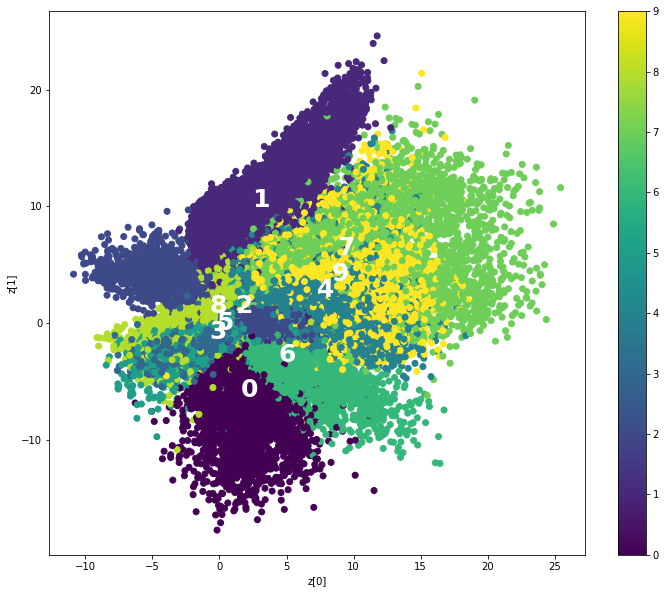

In [9]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=False)

1/1 [==============================] - 0s 12ms/step


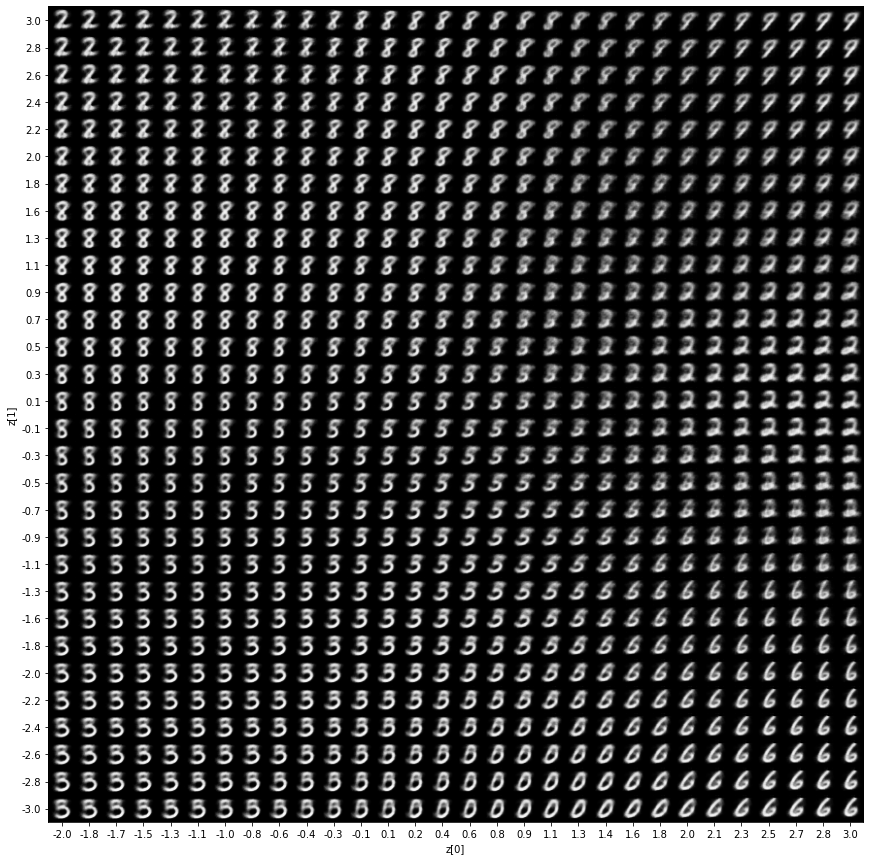

In [10]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.